<a href="https://colab.research.google.com/github/Anuradhagour/project_tuberculosis_detection_using_DL/blob/main/DL_TB_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Step 2: Set the path to dataset (after confirming the folder name and location)
data_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset of Tuberculosis Chest X-rays Images'


#####pip install split-folders: installs the split-folders library, which is used to split a dataset folder into train, validation, and test subfolders
#####pip install split-folders: installs the split-folders library, which is used to split a dataset folder into train, validation, and test subfolders
#####ratio=(0.7, 0.15, 0.15) Defines the percentage of images to split into train (70%), validation (15%), and test (15%).

In [3]:
# STEP 3: Install and Split Dataset
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/Colab Notebooks/Dataset of Tuberculosis Chest X-rays Images', output="Dataset_split", seed=42, ratio=(0.7, 0.15, 0.15))

Copying files: 2985 files [00:48, 61.61 files/s] 


In [4]:
!zip -r test_folder.zip Dataset_split/test


  adding: Dataset_split/test/ (stored 0%)
  adding: Dataset_split/test/TB Chest X-rays/ (stored 0%)
  adding: Dataset_split/test/TB Chest X-rays/TB.1779.jpg (deflated 3%)
  adding: Dataset_split/test/TB Chest X-rays/TB.347.jpg (deflated 1%)
  adding: Dataset_split/test/TB Chest X-rays/TB.1690.jpg (deflated 3%)
  adding: Dataset_split/test/TB Chest X-rays/TB.555.jpg (deflated 2%)
  adding: Dataset_split/test/TB Chest X-rays/TB.2291.jpg (deflated 2%)
  adding: Dataset_split/test/TB Chest X-rays/TB.455.jpg (deflated 2%)
  adding: Dataset_split/test/TB Chest X-rays/TB.2285.jpg (deflated 3%)
  adding: Dataset_split/test/TB Chest X-rays/TB.1344.jpg (deflated 3%)
  adding: Dataset_split/test/TB Chest X-rays/TB.1560.jpg (deflated 2%)
  adding: Dataset_split/test/TB Chest X-rays/TB.308.jpg (deflated 3%)
  adding: Dataset_split/test/TB Chest X-rays/TB.146.jpg (deflated 55%)
  adding: Dataset_split/test/TB Chest X-rays/TB.903.jpg (deflated 1%)
  adding: Dataset_split/test/TB Chest X-rays/TB.779.j

In [5]:
from google.colab import files
files.download('test_folder.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# STEP 4: Remove Corrupt Images # os is a built-in Python module that provides functions to interact with the operating system.
import os                       # It's commonly used for>Navigating folders>Creating or removing directories and files
from PIL import Image           #PIL allows you to open, manipulate, verify, and save images in Python.



In [7]:
def remove_corrupt_images(folder):                  # if Incomplete download>broken file headers>fake extension then remove image
    for label in os.listdir(folder):
        cls_path = os.path.join(folder, label)       #cls_path like: Dataset_split/train/Normal
        for img_file in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_file)
            try:
                img = Image.open(img_path)           #open the image with PIL.
                img.verify()                         #img.verify() checks if the image is valid (header, format, size)
            except:                                  #if an exception is raised it is removed from folder
                os.remove(img_path)

remove_corrupt_images("Dataset_split/train")
remove_corrupt_images("Dataset_split/val")
remove_corrupt_images("Dataset_split/test")

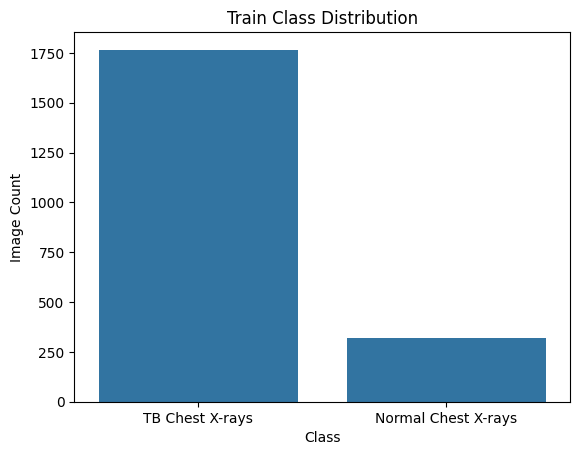

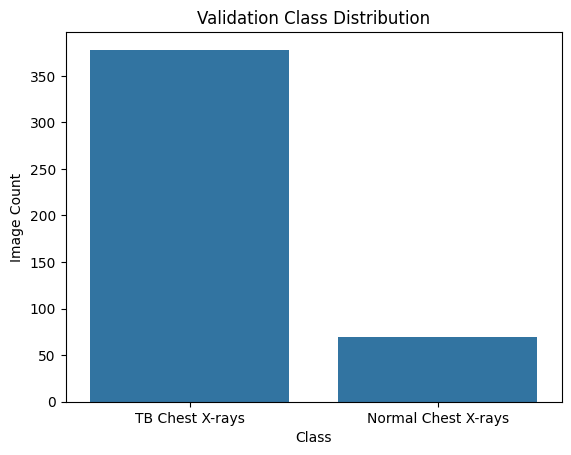

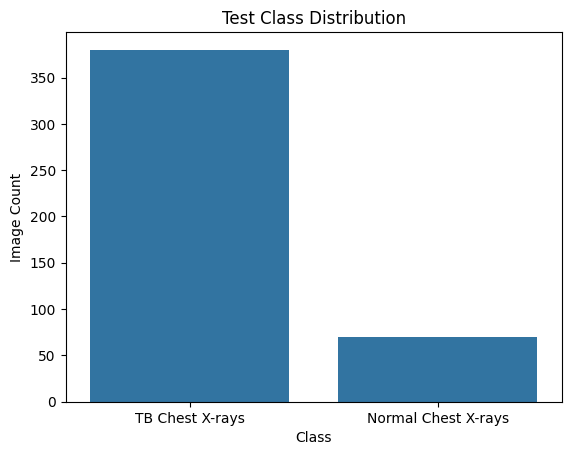

In [8]:
# STEP 5: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 #open-source computer vision library.
import numpy as np

def plot_class_distribution(folder, title):
    labels = []
    for label in os.listdir(folder):                                #gets class folders inside train, val, or test.>'Normal', 'Tuberculosis'
        label_path = os.path.join(folder, label)
        labels.extend([label] * len(os.listdir(label_path)))
    sns.countplot(x=labels)                                        #draws a bar chart of how many images are in each class
    plt.title(title)                                               # title show whether it is tran,test,val.
    plt.xlabel('Class')
    plt.ylabel('Image Count')
    plt.show()

plot_class_distribution("Dataset_split/train", "Train Class Distribution")    #Calls the function 3 times to plot distributions for all dataset splits.
plot_class_distribution("Dataset_split/val", "Validation Class Distribution")
plot_class_distribution("Dataset_split/test", "Test Class Distribution")





In [17]:
# STEP 5: Setup Data Generators
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # It can read images directly from folders and automatically label them based on subfolder names.

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "Dataset_split/train"
val_dir = "Dataset_split/val"
test_dir = "Dataset_split/test"

train_data = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
val_data = test_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test_data = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)


Found 2088 images belonging to 2 classes.
Found 447 images belonging to 2 classes.
Found 450 images belonging to 2 classes.


In [18]:
# STEP 6: Model Builder Function
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model                 #Imports necessary layers and the functional API model class from Keras.

def build_model(base_model, dropout=0.5, dense_units=128):#base_model is CNN that will pass as an input to the build_model fun.like vgg16..
    base_model.trainable = False                          #Freezes all layers (no updates)
    x = base_model.output                                 #Grabs the output tensor from the base model.
    x = GlobalAveragePooling2D()(x)                       #Converts the final convolutional feature map into a single 1D vector by averaging each feature map.
    x = Dense(dense_units, activation='relu')(x)          #Learns complex patterns from the feature maps.
    x = Dropout(dropout)(x)                               #Randomly sets a fraction of inputs to zero during training to prevent overfitting
    output = Dense(1, activation='sigmoid')(x)            #1 neuron → binary classification (Normal vs TB)
    return Model(inputs=base_model.input, outputs=output)

In [19]:
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
import matplotlib.pyplot as plt

def compile_and_train(model, name, epochs=5):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data, validation_data=val_data, epochs=epochs)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    return model

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 34s 474ms/step - accuracy: 0.8054 - loss: 0.4589 - val_accuracy: 0.8837 - val_loss: 0.2454
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 452ms/step - accuracy: 0.8874 - loss: 0.2443 - val_accuracy: 0.9463 - val_loss: 0.1642
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 447ms/step - accuracy: 0.9349 - loss: 0.1701 - val_accuracy: 0.9687 - val_loss: 0.1289
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 442ms/step - accuracy: 0.9482 - loss: 0.1321 - val_accuracy: 0.9732 - val_loss: 0.1123
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 465ms/step - accuracy: 0.9642 - loss: 0.1159 - val_accuracy: 0.9776 - val_loss: 0.0913


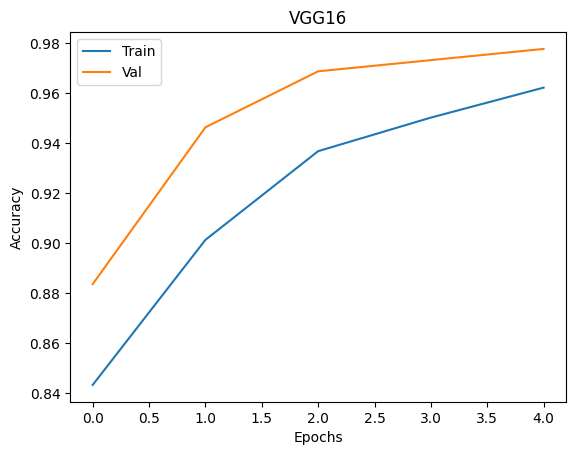

Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 512ms/step - accuracy: 0.8034 - loss: 0.4803 - val_accuracy: 0.8456 - val_loss: 0.4277
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 409ms/step - accuracy: 0.8349 - loss: 0.4500 - val_accuracy: 0.8456 - val_loss: 0.4246
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 402ms/step - accuracy: 0.8354 - loss: 0.4494 - val_accuracy: 0.8456 - val_loss: 0.4307
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 425ms/step - accuracy: 0.8429 - loss: 0.4467 - val_accuracy: 0.8456 - val_loss: 0.4207
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 405ms/step - accuracy: 0.8419 - loss: 0.4370 - val_accuracy: 0.8456 - val_loss: 0.4226


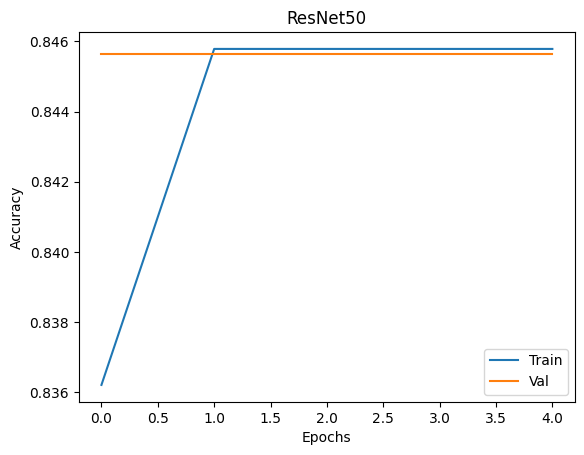

Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 648ms/step - accuracy: 0.8226 - loss: 0.4874 - val_accuracy: 0.8456 - val_loss: 0.4307
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 379ms/step - accuracy: 0.8429 - loss: 0.4454 - val_accuracy: 0.8456 - val_loss: 0.4308
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 389ms/step - accuracy: 0.8456 - loss: 0.4396 - val_accuracy: 0.8456 - val_loss: 0.4341
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 377ms/step - accuracy: 0.8583 - loss: 0.4206 - val_accuracy: 0.8456 - val_loss: 0.4344
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 377ms/step - accuracy: 0.8434 - loss: 0.4466 - val_accuracy: 0.8456 - val_loss: 0.4322


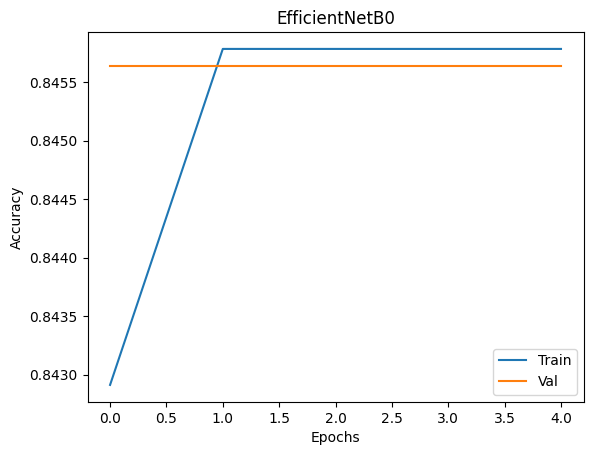

In [20]:
# VGG16
vgg_model = build_model(VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)), dropout=0.5)
vgg_model = compile_and_train(vgg_model, "VGG16")

# ResNet50
resnet_model = build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3)), dropout=0.3)
resnet_model = compile_and_train(resnet_model, "ResNet50")

# EfficientNetB0
effnet_model = build_model(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3)), dropout=0.4)
effnet_model = compile_and_train(effnet_model, "EfficientNetB0")

In [21]:

# STEP 8: Evaluate Best Model
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

def evaluate_model(model):
    y_pred_probs = model.predict(test_data)
    y_pred = (y_pred_probs > 0.5).astype('int32')
    y_true = test_data.classes
    print(classification_report(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_pred_probs))

print("\nEvaluating VGG16:")
evaluate_model(vgg_model)
print("\nEvaluating ResNet50:")
evaluate_model(resnet_model)
print("\nEvaluating EfficientNetB0:")
evaluate_model(effnet_model)



Evaluating VGG16:
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        70
           1       0.99      0.97      0.98       380

    accuracy                           0.96       450
   macro avg       0.91      0.95      0.93       450
weighted avg       0.97      0.96      0.96       450

ROC-AUC: 0.9894360902255639

Evaluating ResNet50:
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 306ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.84      1.00      0.92       380

    accuracy                           0.84       450
   macro avg       0.42      0.50      0.46       450
weighted avg       0.71      0.84      0.77       450

ROC-AUC: 0.9373684210526316

Evaluating EfficientNetB0:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 491ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.84      1.00      0.92       380

    accuracy                           0.84       450
   macro avg       0.42      0.50      0.46       450
weighted avg       0.71      0.84      0.77       450

ROC-AUC: 0.8590037593984962


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# STEP 9: Save Best Model###VGG16 is performing best
vgg_model.save('/content/drive/MyDrive/vgg16_tb_model.keras')